<a href="https://colab.research.google.com/github/seungmei/ESAA_24_1/blob/main/0318%EC%9B%94%EA%B3%BC%EC%A0%9C_%ED%95%B8%EC%A6%88%EC%98%A8_Ch7_%EC%95%99%EC%83%81%EB%B8%94_%ED%95%99%EC%8A%B5%EA%B3%BC_%EB%9E%9C%EB%8D%A4_%ED%8F%AC%EB%A0%88%EC%8A%A4%ED%8A%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0318월과제 핸즈온 Ch7 앙상블 학습과 랜덤 포레스트

- 여러개의 예측기(앙상블)로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있을 것이다: **앙상블 학습 ensemble learning**
e.g. 훈련 세트에서 무작위로 각기 다른 서브셋 만들기 -> 일련의 결정트리 분류기 훈련시킴. -> -> 모든 개별 트리의 예측 구하기 -> 가장 많은 선택을 받은 클래스를 예측 : 결정 트리의 앙상블 : **Random Forest**
  - 공모전에서 우승하려면 *여러가지 앙상블 방법 사용해야! 필승!*

In [4]:
import warnings
warnings.filterwarnings('ignore')

# import package
import numpy as np
import os

#5장에서 소개한 moons dataset 불러오기
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X,y = make_moons(n_samples=100, noise=0.15)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## 7.1 투표 기반 분류
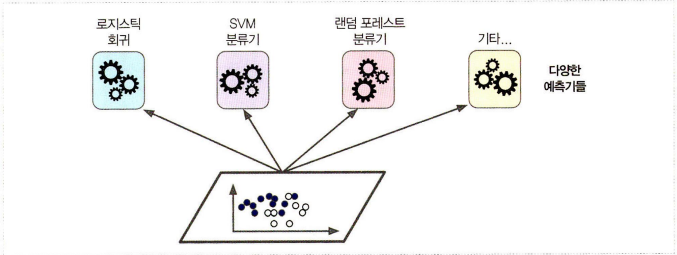

각 분류기의 예측을 모아서 가장 많이 선택된 클래스 예측; hard voting
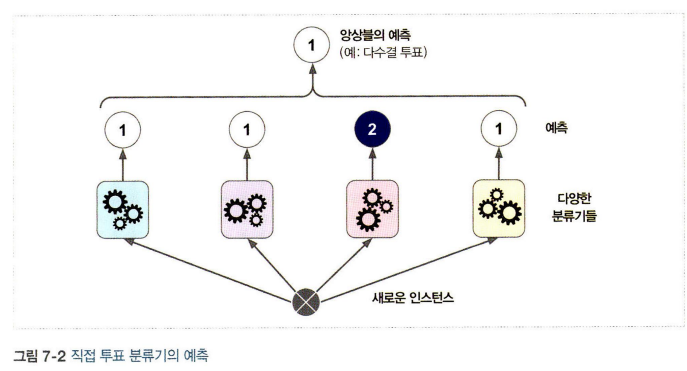


각 분류기가 weak learner일지라도, 앙상블이 되면 strong learner가 된다
"뭉치면 살고 흩어지면 죽는다"
why? 51%의 정확도를 가진 1000개의 분류기로 앙상블 모델을 구축한다고 가정. 가장 많은 클래스를 예측으로 삼으면 75% 정확도 기대 可

In [6]:
#여러 분류기 조합하여 사이킷런의 투표 기반 분류기를 만들고 훈련시킴.
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression()
rnd_clf = RandomForestClassifier()
svm_clf = SVC()

voting_clf = VotingClassifier(
    estimators = [('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard'
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('rf', RandomForestClassifier()), ('svc', SVC())])

In [9]:
#각 분류기의 테스트셋 정확도 확인
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  print(clf.__class__.__name__, accuracy_score(y_test, y_pred))
## 투표 기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높

LogisticRegression 0.75
RandomForestClassifier 0.85
SVC 1.0
VotingClassifier 0.95


- soft voting: 개별 분류기의 예측을 평균내어 확률이 가장 높은 클래스 예측. voting='soft'

## 7.2 배깅과 페이스팅
- 배깅bagging: 훈련 세트에서 중복을 허용하여 샘플링하는 방식
- 페이스팅pasting: 중복을 허용하지 않고 샘플링하는 방식
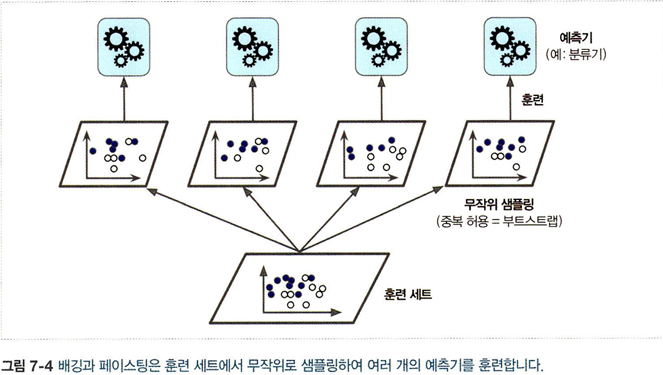

- 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 만듦. 수집 함수는 분류일 때는 *통계적 최빈값*이고, 회귀에 대해서는 *평균* 계산.
  - 개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향되어 있음. but, 수집 함수를 통과하면 편향과 분산이 모두 감소.
  - 일반적으로 앙상블의 결과는 원본 데이터셋으로 하나의 예측기를 훈련시킬 떄와 비교해 편향은 비슷하지만 분산은 줄어듦.

### 7.2.1 사이킷런의 배깅과 페이스팅
- BaggingRegressor

In [14]:
'''
결정 트리 분류기 500개의 앙상블 훈련시키기
각 분류기는 훈련 세트에서 중복 허용, 무작위 선택 100개 샘플.
페이스팅 사용시, boostrap=False 지정
n_jobs 매개변수: CPU 코어 수 지정 (-1: 가용한 모든 코어 사용)
'''
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(

    DecisionTreeClassifier(), n_estimators=500,
    max_samples=50, bootstrap=True, n_jobs=-1

)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

Note. BaggingClassifier는 기반 분류기가 결정 트리 분류기처럼 클래스 확률을 추정할 수 있으면(=predict_proba() 함수가 있으면) 자동으로 간접 투표 방식을 사용

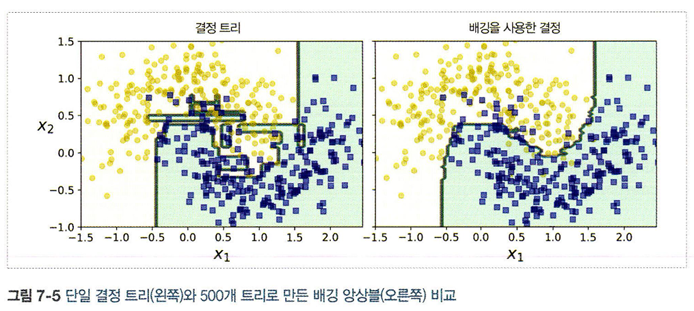

일반적으로 배깅이 더 나은 모델을 만듦.

### 7.2.2 obb 평가
- BaggingClassifier는 기본값으로 중복을 허용(bootstrap=True) -> 훈련 세트 크기만큼인 m개 샘플 선택. => 각 예측기에 훈련 샘플 63%만 샘플링된다는 것을 의미. 선택되지 않은 훈련 샘플의 나머지 37%: oob(out-of-bag) 샘플

In [17]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True
)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9125

In [18]:
#테스트 세트에서의 정확도
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9

In [19]:
bag_clf.oob_decision_function_

array([[0.        , 1.        ],
       [0.99444444, 0.00555556],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.82653061, 0.17346939],
       [0.58510638, 0.41489362],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.02424242, 0.97575758],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.96650718, 0.03349282],
       [0.81081081, 0.18918919],
       [0.78971963, 0.21028037],
       [0.74725275, 0.25274725],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.04519774, 0.95480226],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.99462366, 0.00537634],
       [0.36138614, 0.63861386],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [0.60465116, 0.39534884],
       [1.

## 7.3 랜덤 패치와 랜덤 서브스페이스
- BaggingClassifier는 특성 샘플링도 지원.
  - max_features
  - bootstrap_features
- 훈련 특성과 샘플을 모두 샘플링하는 것: random patches method
- 훈련 샘플을 모두 사용, 특성은 샘플링하는 것: random subspaces method
- ==> 특성 샘플링은 더 다양한 예측기를 만들며 편향을 ↑ 분산 ↓

## 7.4 랜덤 포레스트
: 일반적으로 배깅(or 페이스팅)을 적용한 결정 트리의 앙상블
  - max_samples: 훈련 세트의 크기로 지정
  - DecisionTreeClassifier의 매개변수와 BaggingClassifier의 매개변수 모두 가지고 있음.

In [20]:
#500개 트리로 이뤄진 랜덤 포레스트 분류기를 여러 CPU 코어에서 훈련
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [23]:
# Bagging을 사용해 앞의 RandomFOrest와 거의 유사하게 만들기
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='auto', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1
)

### 7.4.1 엑스트라 트리
: 극단적으로 무작위한 트리의 랜덤 포레스트. 편향 ↑, 분산 ↓.
- 일반적 랜덤 포레스트보다 엑스트라가 훨씬 빠름.

### 7.4.2 특성 중요도
- 랜덤 포레스트의 장점: 특성의 상대적 중요도 측정 쉬움. 어떤 특성을 사용한 노드가 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정.
가중치 평균, 각 노드의 가중치는 연관된 훈련 샘플 수와 같음.

In [24]:
#각 특성 중요도 출력
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
  print(name, score)

sepal length (cm) 0.10728758681255254
sepal width (cm) 0.02705723088146753
petal length (cm) 0.4293693234921174
petal width (cm) 0.43628585881386245


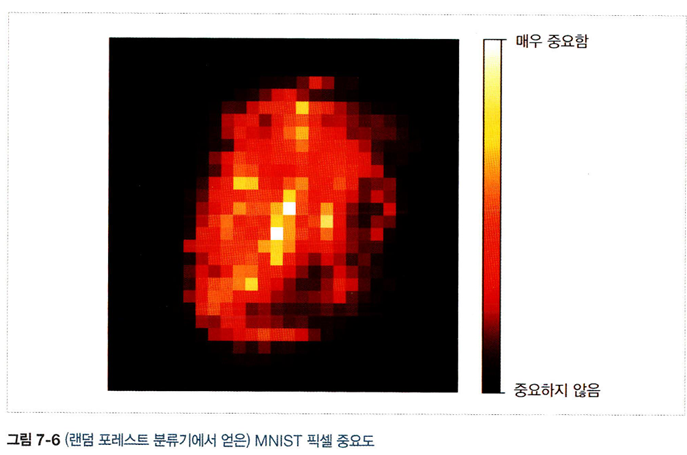

## 7.5 부스팅
: 약한 학습기 여러개 연결하여 강한 학습기를 만드는 앙상블 방법
- AdaBoost
- GradientBoosting

### 7.5.1 에이다부스트
:이전 예측기를 보완하기 위해 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높이기. 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰짐.
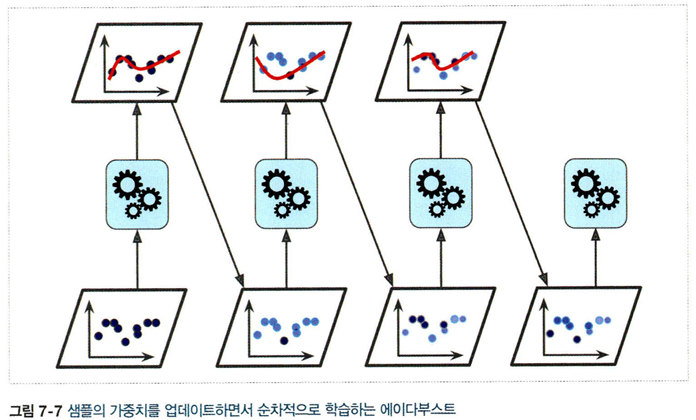

- 에이다부스트는 모델파라미터 조정X, 앙상블에 예측기 추가O.
- 모든 예측기가 훈련을 마치면 앙상블은 배깅이나 페이스팅과 비슷한 방식으로 예측을 만듦.

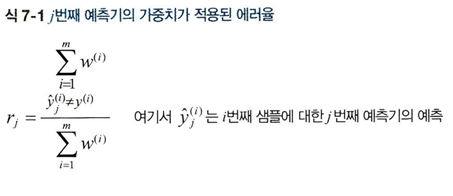

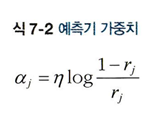

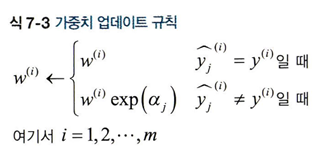

가중치 합이 가장 큰 클래스가 예측 결과가 됨.
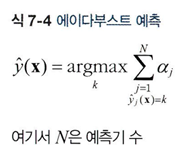

In [25]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm='SAMME.R', learning_rate=0.5
)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

### 7.5.2 그레이디언트 부스팅
: 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가. 단, 잔여 오차에 새로운 예측기 학습시킴

In [27]:
#DecisionTree를 훈련세트에 학습
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)
tree_reg1.fit(X,y)

DecisionTreeRegressor(max_depth=2)

In [28]:
#첫번째 예측기에서 생긴 잔여 오차에 두번째 DecisionTree를 훈련
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [29]:
#두번째 예측기가 만든 잔여 오차에 세번째 회귀 모델 훈련
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [31]:
#y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [32]:
#앙상블
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X,y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

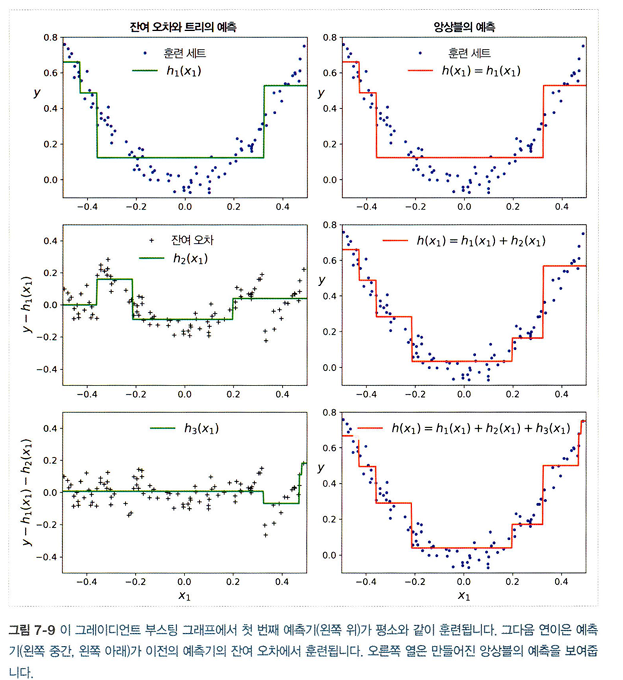

- learning_rate: 각 트리의 기여 정도를 조절. 0.1처럼 낮게 설정시 앙상블을 훈련 세트에 학습시키기 위해 많은 트리 필요, but 예측 성능은 좋아짐. : 축소 shrinkage
  - 그림 7-10에서 왼쪽은 훈련 세트를 학습하기에는 트리 충분X. 오른쪽은 트리 너무 많아 과대적합.
  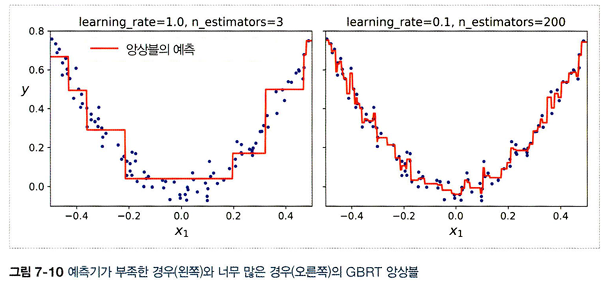

In [33]:
#최적의 트리 수를 찾기 by. 조기 종료 기법 staged_predict()
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=14)

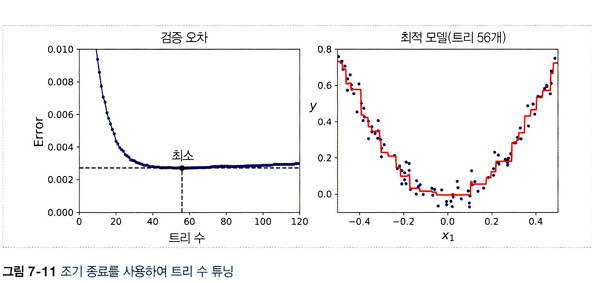

In [35]:
#warm_start=True: fit()이 호출될 때 기존 트리를 유지하고 추가
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1, 120):
  gbrt.n_estimators = n_estimators
  gbrt.fit(X_train, y_train)
  y_pred = gbrt.predict(X_val)
  val_error = mean_squared_error(y_val, y_pred)
  if val_error < min_val_error:
    min_val_error = val_error
    error_going_up = 0
  else:
    error_going_up += 1
    if error_going_up == 5:
      break #조기종료

- subsample=0.25 : 25%의 무작위 선택된 훈련 샘플로 학습 => 편향 ↑, 분산 ↓, 훈련속도 ↑: stochastic gradient boosting확률적 그레디언트 부스팅
  - XGBoost(extreme gradient boosting)

In [36]:
import xgboost

xgb_reg = xgboost.XGBRegressor()
xgb_reg.fit(X_train, y_train)
y_pred = xgb_reg.predict(X_val)

In [37]:
xgb_reg.fit(X_train, y_train,
            eval_set = [(X_val, y_val)], early_stopping_rounds=2)
y_pred = xgb_reg.predict(X_val)

[0]	validation_0-rmse:0.41322
[1]	validation_0-rmse:0.37102
[2]	validation_0-rmse:0.35599
[3]	validation_0-rmse:0.35478
[4]	validation_0-rmse:0.34818
[5]	validation_0-rmse:0.34606
[6]	validation_0-rmse:0.34593
[7]	validation_0-rmse:0.34979
[8]	validation_0-rmse:0.34707


## 7.6 스태킹stacking
: 앙상블에 속한 모든 예측기의 예측 취합X, 취합하는 모델 훈련O.
- 마지막 예측기(blender or meta learner)가 이 예측을 입력으로 받아 최종 예측을 만듦.

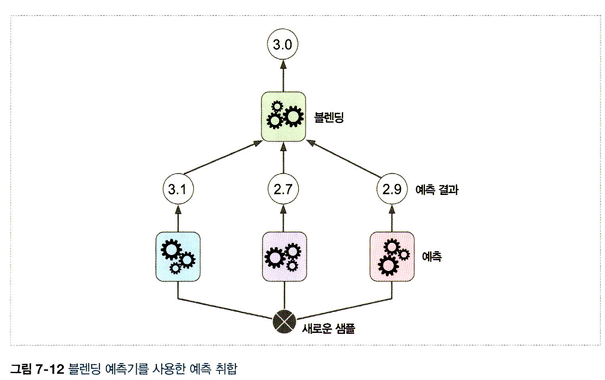

- 블렌더를 학습시키는 일반적인 방법은 hold-out 세트 사용
- 먼저 훈련 세트를 두 개의 서브셋으로 나눔. 첫번쨰 서브셋은 첫번째 레이어의 예측을 훈련시키기 위해 사용.
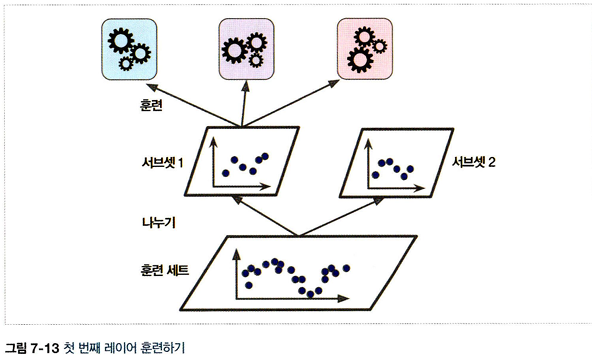

- 그 후에 첫번쨰 레이어의 예측기를 사용해 두번째(홀드아웃) 세트에 대한 예측을 만듦.
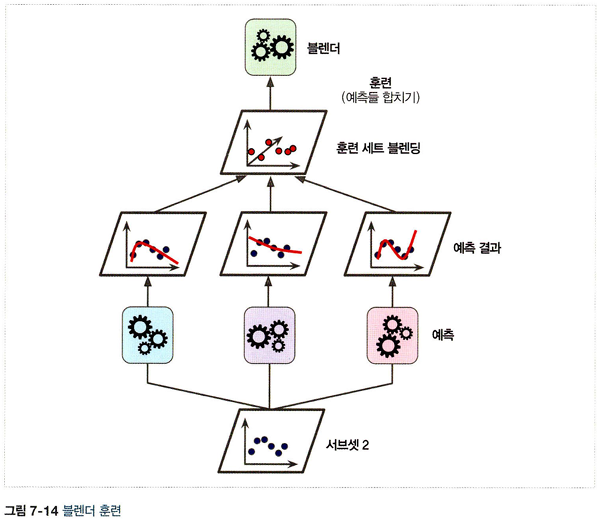

- 블렌더 여러개 훈련시키는 것도 가능. (하나는 선형 회귀, 다른 하나는 랜덤포레스트회귀 이런 식으로.)

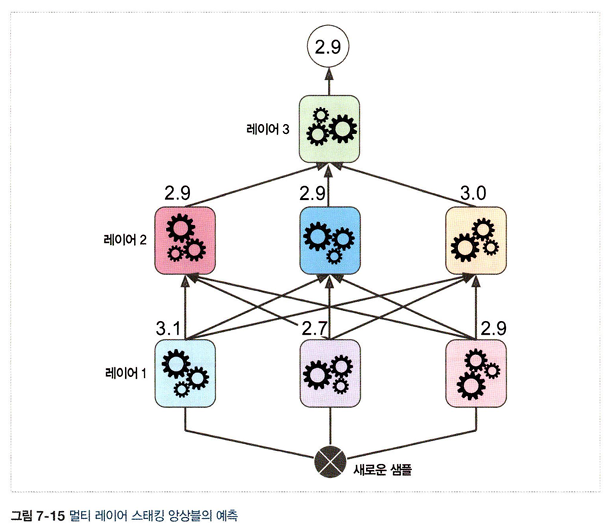